# Training the final model

This notebook is supplementary material to the project here, which aims to re-implement the Hubble.2d6 tool to predict the function of CYP2D6 star alleles.

Within this notebook, the final model in the sequence outlined in the paper is trained using transfer learning. Weights from the first step are loaded into the new model. The fully-connected layers of the first model are replaced with new, randomly initialised layers and trained on 31 star alleles and their respective suballeles.

Please keep in mind that this implementation is incomplete due to the lack of resources to compute robust annotation embeddings of all variants for all star alleles.

Additionally, in the paper, this model is supposed to instead have its weights - along with weights of one of the fully-connected layers - loaded in from the second model in the sequence. However, due to data availability, I was unable to reproduce the implementation of the second model and instead chose to transfer just the convolution layers' weights to the final model from the first model that was trained on simulated data.

## Getting ready

**Acknowledgements**: Pre-computed annotation embeddings used are form the original Hubble.2d6 repo: https://github.com/gregmcinnes/Hubble2D6/tree/master/data

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1337)

In [3]:
!git clone https://github.com/Locrian24/seng474-term-project.git
!cd seng474-term-project/ && git pull

fatal: destination path 'seng474-term-project' already exists and is not an empty directory.
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 3), reused 12 (delta 3), pack-reused 0
Unpacking objects: 100% (12/12), done.
From https://github.com/Locrian24/seng474-term-project
   1e596b9..ef1a81e  main       -> origin/main
Updating 1e596b9..ef1a81e
Fast-forward
 data/ensemble_models/archive2/ensemble_0.model.h5 | Bin 0 -> 647856 bytes
 data/ensemble_models/archive2/ensemble_1.model.h5 | Bin 0 -> 647856 bytes
 data/ensemble_models/archive2/ensemble_2.model.h5 | Bin 0 -> 647856 bytes
 data/ensemble_models/archive2/ensemble_3.model.h5 | Bin 0 -> 647856 bytes
 data/ensemble_models/archive2/ensemble_4.model.h5 | Bin 0 -> 647856 bytes
 data/ensemble_models/archive2/ensemble_5.model.h5 | Bin 0 -> 647856 bytes
 data/ensemble_models/archive2/ensemble_6.model.h5 | Bin 0 -> 647856 bytes
 data/e

In [4]:
import sys
sys.path.insert(0, '/content/seng474-term-project/model')

## Preparing the data

The vcf file of the star alleles used were provided from the paper and can be found **here**. 

### Encoding method

The script `build_label_csv.py` was run on this vcf file to output the label csv that will be used for training.

Labels for the data correspond to the ordinal classes describing the function of each CYP2D6 star allele and their respective suballeles: "No function", "Decreased function", and "Normal function".

The model however is required to output two scores, representing the probability of a star allele being "No function" and "Normal function" respectively, and therefore a binary scoring system is used to encode the 3 function classes into these two scores. 

The scoring system is as follows:
- "No function" alleles are indicated with a 0 as the first score, with all other functions being denoted with a 1
- "Normal function" alleles are indicated with a 1 as the second score, with all other functions being denoted with a 0.

This yields the following encodings:
- "No function" = `[0, 0]`
- "Decreased function" = `[0, 1]`
- "Normal function" = `[1, 1]`

**Note**: Star alleles with uncurated function have an empty label (`[None, None]`). 

_Sequence encodings are done exactly the same as in step 1_

In [5]:
from encode_to_seq import Encode2Seq

# Global variables rn for testing

ANNOTATIONS = '/content/seng474-term-project/data/gvcf2seq.annotation_embeddings.csv'
EMBEDDINGS = '/content/seng474-term-project/data/embeddings.txt'
REF = '/content/seng474-term-project/data/ref.seq'

VCF = '/content/seng474-term-project/step3/data/star_samples.vcf'
LABELS = '/content/seng474-term-project/step3/data/labels.csv'

encoding = Encode2Seq(vcf=VCF, labels=LABELS, label_cols=[0, 1, 2], embedding_file=EMBEDDINGS, annotation_file=ANNOTATIONS, ref_seq=REF)

### Seperation of data sets

The paper indicates that they used 31 star alleles and their suballeles as training data, and 24 alleles to compose the test data. Additionally, 10% of the each functional class ("No function", "Decreased function", and "Normal function") were held out for validation during training.

All star alleles with "Uncurated function" were ignored, and held from training/testing for obvious reasons.

In [6]:
# Select only star alleles with curated function

mask = np.all(np.isnan(encoding.y) == False, axis=1)

sample_y = encoding.y[mask]
sample_X = encoding.X[mask.reshape(-1, 1).any(axis=1)]
sample_names = encoding.sample_names[mask]

In [7]:
# Get valid stars
all_stars = np.array([s.split('_')[1] for s in sample_names])
stars, idx = np.unique(all_stars, return_index=True)

# Choose which stars are training and which are test: (31, 24) split
# Should be stratified with labels
train_idx, test_idx = train_test_split(idx, stratify=sample_y[idx], test_size=24, random_state=1)

# Retrieve indices of training and test stars
sample_mask = np.isin(all_stars, all_stars[train_idx])

test_stars = np.array([s for s in sample_names[~sample_mask] if s.split('_')[-1] == '001'])
test_mask = np.isin(sample_names, test_stars)

train_stars = np.array([s for s in sample_names[sample_mask] if s.split('_')[-1] == '001'])
train_mask = np.isin(sample_names, train_stars)

# Split the data into the two sets - INCLUDING SUBALLES ON BOTH
_train_X, test_X = sample_X[sample_mask], sample_X[~sample_mask]
_train_y, test_y = sample_y[sample_mask], sample_y[~sample_mask]

# Purely for evaluation (paper looks at star allele accuracy rather than star + suballeles)
star_train_X, star_test_X = sample_X[train_mask], sample_X[test_mask]
star_train_y, star_test_y = sample_y[train_mask], sample_y[test_mask]

# Split training into train + validation (10% split -> validation)
train_X, val_X, train_y, val_y = train_test_split(_train_X, _train_y, stratify=_train_y, test_size=0.1, random_state=1)

In [8]:
# Uncurated star alleles

uncurated_samples = encoding.sample_names[~mask]
uncurated_stars = np.array([s for s in uncurated_samples if s.split('_')[-1] == '001'])
uncurated_star_mask = np.isin(uncurated_samples, uncurated_stars)

uncurated_samples = uncurated_samples[uncurated_star_mask]
uncurated_X = encoding.X[(~mask).reshape(-1, 1).any(axis=1)]
uncurated_X = uncurated_X[uncurated_star_mask]

### Prepare data for the model

In [9]:
_train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_ds = _train_ds.shuffle(train_X.shape[0], reshuffle_each_iteration=True).repeat().batch(32).prefetch(buffer_size=10)

_val_ds = tf.data.Dataset.from_tensors((val_X, val_y))
val_ds = _val_ds.prefetch(buffer_size=10)

_test_ds = tf.data.Dataset.from_tensors((test_X, test_y))
test_ds = _test_ds.prefetch(buffer_size=10)

## Building the final model

As stated earlier, the model is loaded from the generated model from step 1, and also inherits its learned weights.

In [10]:
epochs = 8
fine_tune_epochs = 2

def build_and_fit(train_dataset, val_dataset):
  json_file = open('/content/seng474-term-project/step_1/model.json', 'r')
  loaded_model = json_file.read()
  model = tf.keras.models.model_from_json(loaded_model)
  model.load_weights('/content/seng474-term-project/step_1/weights.h5')
  
  # Remove fully connected layers
  model.pop()
  model.pop()
  model.pop()
  model.trainable = False

  # Build final model
  inputs = tf.keras.Input(shape=(14868, 13))
  x = model(inputs, training=False)
  x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.VarianceScaling(mode='fan_avg', distribution='uniform'), name = "dense_5")(x)
  x = tf.keras.layers.Dropout(rate=0.03, name="dropout_4")(x)
  x = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer=tf.keras.initializers.VarianceScaling(mode='fan_avg', distribution='uniform'), name = "dense_6")(x)
  outputs = tf.keras.layers.Dense(2, activation=tf.keras.activations.sigmoid, kernel_initializer=tf.keras.initializers.VarianceScaling(mode='fan_avg', distribution='uniform'), name = "final_dense")(x)
  final_model = tf.keras.Model(inputs, outputs)

  # Initial training
  final_model.compile(
    optimizer=tf.keras.optimizers.SGD(0.1, momentum=0.8, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()]
  )

  final_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, steps_per_epoch=32, validation_steps=1)

  # Fine tuning
  model.trainable = True
  final_model.compile(
      optimizer=tf.keras.optimizers.SGD(1e-5, momentum=0.8, nesterov=True),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()]
  )

  final_model.fit(train_dataset, epochs=fine_tune_epochs, validation_data=val_dataset, steps_per_epoch=32, validation_steps=1)
  
  return final_model

## Training ensemble models

Hubble.2d6 uses an ensemble averaging method for it's final predictions. Here we are training 7 models to use in the ensemble, report the training accuracy of each and save these models for the final tool.

This is commented out since it was run to obtain the final weights used in the final model implemented seperately

In [11]:
# ensemble_size = 7

# for i in range(ensemble_size):
#   print(f"ensemble_{i}.model.h5")
#   model = build_and_fit(train_ds, val_ds)

#   model.save(f'models/ensemble_{i}.model.h5')

Now that we have the ensemble models saved, we will use them for the final prediction.

### Important

From now on, we use the final version of the paper implementation to show true performance.

It is definitely possible to change the path where the weights exist in the colab project and train a new ensemble above.

## Building the ensemble

This step is identical to how the final implementation of this project builds the ensemble, with its purpose being here for evaluation purposes.

**Note**: In development, this notebook was run and the weights are already saved for the final model

In [12]:
class Ensemble():
  def __init__(self, X=None):
    self.X = X
    self.raw = None
    self.predictions = None

    self.run()

  def run(self):
    predictions = self.predict(self.X).mean(axis=0)
    self.raw = predictions
    self.predictions = self.get_functions(predictions)

  def get_functions(self, pred):
    cutpoint_1 = 0.4260022
    cutpoint_2 = 0.7360413

    cut1 = np.greater(pred[:, 0], [cutpoint_1])
    cut2 = np.greater(pred[:, 1], [cutpoint_2])

    functions = []
    for i in range(pred.shape[0]):
      if cut1[i] == True and cut2[i] == True:
        functions.append("Normal")
      elif cut1[i] == True and cut2[i] == False:
        functions.append("Decreased function")
      else:
        functions.append("No function")

    return np.array(functions)

  def evaluate(self, y):
    labels = self.get_functions(y)
    return np.sum(labels == self.predictions) / len(y)

  def predict(self, X):
    from glob import glob
    dir = '/content/seng474-term-project/data/ensemble_models/'
    models = glob(dir + "*.model.h5")
    
    predictions = []
    for m in models:
      print(f"Predicting using {m}")
      model = tf.keras.models.load_model(m)
      
      pred = model.predict(X)
      predictions.append(pred)

    return np.array(predictions)

In [13]:
# Training data - INCLUDES SUBALLELES

train_ensemble = Ensemble(train_X)
print("\nTraining Accuracy (with suballeles):", train_ensemble.evaluate(train_y))

Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_4.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_6.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_0.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_1.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_2.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_5.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_3.model.h5

Training Accuracy (with suballeles): 0.8671328671328671


In [14]:
# Original paper attains 100% accuracy on training data star alleles

star_train_ensemble = Ensemble(star_train_X)
print("\nTraining Accuracy (only star alleles):", star_train_ensemble.evaluate(star_train_y))

Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_4.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_6.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_0.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_1.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_2.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_5.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_3.model.h5

Training Accuracy (only star alleles): 0.8387096774193549


In [15]:
# Validation data - INCLUDES SUBALLELES

val_ensemble = Ensemble(val_X)

print("\nValidation Accuracy:", val_ensemble.evaluate(val_y))

Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_4.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_6.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_0.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_1.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_2.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_5.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_3.model.h5

Validation Accuracy: 0.8125


## Initial Evaluation

The purpose here is to properly quantify the accuracy of predictions by decoding the scoring system into their respective labels.

**Note:** Training and validation sets contain suballele predictions. Suballeles of a given star allele _should_ have the same prediction, and so some star alleles with many more suballeles than others may affect the accuracy score. As a result, training data is evaluated 

In [16]:
import seaborn as sb
import matplotlib.pyplot as plt

def build_heatmap(pred, y, labels):
  heatmap = []
  for label in labels:
    mask = pred == label
    masked_labels = y[mask]
    heatmap.append([len(masked_labels[masked_labels == l]) for l in reversed(labels)])

  return heatmap

[Text(0.5, 33.0, 'True function'), Text(0.5, 1.0, 'Validation set')]

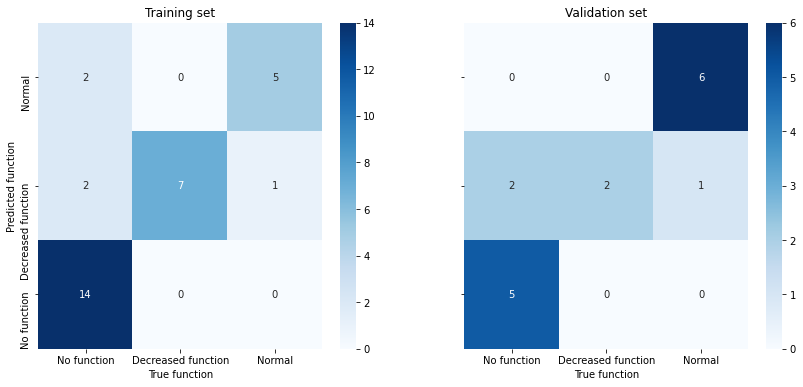

In [18]:
labels = ["Normal", "Decreased function", "No function"]

train_labels = star_train_ensemble.get_functions(star_train_y)
val_labels = val_ensemble.get_functions(val_y)

train_heatmap = build_heatmap(star_train_ensemble.predictions, train_labels, labels)
val_heatmap = build_heatmap(val_ensemble.predictions, val_labels, labels)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(14, 6)

sb.heatmap(train_heatmap, cmap="Blues", annot=train_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels, ax=ax1)
sb.heatmap(val_heatmap, cmap="Blues", annot=val_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels, ax=ax2)

ax1.set(xlabel="True function", ylabel="Predicted function", title="Training set")
ax2.set(xlabel="True function", title="Validation set")

## Final Evaluation

Here we evaluate the final predictive ability of the implementation of the Hubble.2d6 paper.

Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_4.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_6.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_0.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_1.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_2.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_5.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_3.model.h5

Test Accuracy + suballeles: 0.7017543859649122


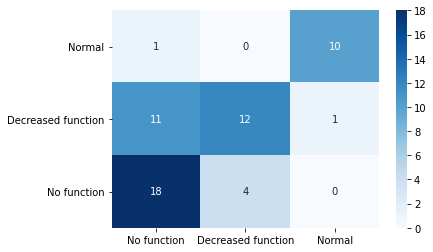

In [19]:
# All test star alleles + suballeles

test_ensemble = Ensemble(test_X)
test_labels = test_ensemble.get_functions(test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)

print("\nTest Accuracy + suballeles:", test_ensemble.evaluate(test_y))

Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_4.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_6.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_0.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_1.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_2.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_5.model.h5
Predicting using /content/seng474-term-project/data/ensemble_models/ensemble_3.model.h5

Test Accuracy: 0.75


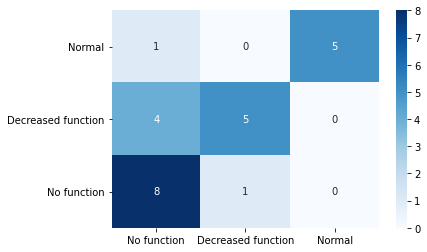

In [20]:
# All test star alleles

test_ensemble = Ensemble(star_test_X)
test_labels = test_ensemble.get_functions(star_test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)

print("\nTest Accuracy:", test_ensemble.evaluate(star_test_y))

As you can see, on only star alleles, we achieve around 75% accuracy. With more inaccuracy with the set containing all respective suballeles.

Based on the heatmap, the biggest error in prediction (on the test set) is a higher rate of predicting "Decreased Function" on haplotype with "No Function"